In [1]:
import typing as t
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [3]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [4]:
DATA_DIR = Path("../data/")

CUDA = "cuda"
CPU = "cpu"
DEVICE = CUDA if torch.cuda.is_available() else CPU
print(f"Using {DEVICE.upper()} device")

Using CUDA device


## Предобработка данных и подготовка датасета

In [5]:
def unique_stat(df: pd.DataFrame) -> pd.Series:
    uniq_stat = df.nunique()
    return uniq_stat[(uniq_stat == 1) | (uniq_stat == len(df))]


def na_stat(df: pd.DataFrame) -> pd.Series:
    stat = df.isna().sum()
    return stat[stat > 0]


def duplicates_stat(df: pd.DataFrame) -> pd.Series:
    return df[df.duplicated()].value_counts()


def get_categorical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(object).columns


def get_numerical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(np.number).columns


def count_categories(df: pd.DataFrame) -> pd.Series:
    return df[get_categorical_columns(df)].nunique()

In [6]:
credit_df: pd.DataFrame = pd.read_csv(DATA_DIR / "classification/credit.csv")
print(credit_df.shape)
credit_df.head()

(24000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,90000,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
2,50000,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
3,50000,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
4,50000,1,1,2,37,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0


In [7]:
unique_stat(credit_df)

Series([], dtype: int64)

In [8]:
na_stat(credit_df)

Series([], dtype: int64)

In [9]:
duplicates_stat(credit_df)

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default
20000      1    2          2         24    2      2      4      4      4      4     1650.0     1650.0     1650.0     1650.0     1650.0     1650.0     0.0       0.0       0.0       0.0       0.0       0.0       1          1
50000      1    2          2         26    1     -2     -2     -2     -2     -2     0.0        0.0        0.0        0.0        0.0        0.0        0.0       0.0       0.0       0.0       0.0       0.0       0          1
360000     2    1          2         29    1     -2     -2     -2     -2     -2     0.0        0.0        0.0        0.0        0.0        0.0        0.0       0.0       0.0       0.0       0.0       0.0       0          1
                           1         41   -2     -2     -2     -2     -2     -2     0.0        0.0        0.0    

In [10]:
credit_df = credit_df.drop_duplicates()
duplicates_stat(credit_df)

Series([], dtype: int64)

In [11]:
print(credit_df.shape)
credit_df.head()

(23976, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,90000,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
2,50000,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
3,50000,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
4,50000,1,1,2,37,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0


0    18675
1     5301
Name: default, dtype: int64


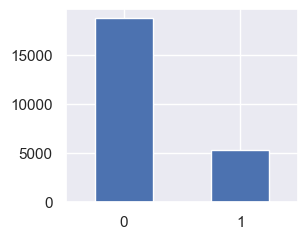

In [12]:
vc = credit_df["default"].value_counts()
print(vc)
credit_df["default"].value_counts().plot.bar(rot=0, figsize=(3, 2.5));

In [13]:
class CreditDataset(Dataset):
    scaler: StandardScaler
    num_features: int
    classes: t.List[str]

    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, scaler: StandardScaler = None):
        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        target_col = "default"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        self.data = torch.tensor(scale(data), dtype=torch.float)
        self.num_features = self.data.size(1)
        self.targets = torch.tensor(targets.to_numpy(), dtype=torch.long)
        self.classes = [str(cls) for cls in targets.unique()]

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [14]:
train_df, test_df = train_test_split(credit_df, test_size=0.2, random_state=0)

train_dataset = CreditDataset(train_df)
test_dataset = CreditDataset(test_df, scaler=train_dataset.scaler)
len(train_dataset), len(test_dataset), train_dataset.num_features, train_dataset.classes

(19180, 4796, 23, ['1', '0'])

## Построение и обучение модели

In [15]:
def get_weights(targets: torch.Tensor) -> torch.Tensor:
    _, counts = targets.unique(return_counts=True)
    return counts.max() / counts


def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        epochs: int,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[t.List[float], t.List[float], t.List[float], t.List[float]]:
    train_losses, train_accuracy_list = [], []
    test_losses, test_accuracy_list = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)

        train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer, verbose, device)
        print(f"Train Error: loss: {train_loss:.6f}, accuracy: {train_accuracy:.4f}")
        train_losses.append(train_loss)
        train_accuracy_list.append(train_accuracy)

        test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)
        print(f" Test Error: loss: {test_loss:.6f}, accuracy: {test_accuracy:.4f}\n")
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        torch.cuda.empty_cache()
    return train_losses, train_accuracy_list, test_losses, test_accuracy_list


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, avg_accuracy = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_true = torch.flatten(y).detach().cpu()
        y_pred = torch.flatten(pred.argmax(1)).detach().cpu()
        accuracy = metrics.accuracy_score(y_true, y_pred)

        avg_loss += loss
        avg_accuracy += accuracy
        if verbose and batch % verbose == 0:
            print(f"[{batch * len(x):>4d}/{size:>4d}]: loss: {loss:.6f}, accuracy: {accuracy:.4f}")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return (avg_loss / num_batches).item(), avg_accuracy / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader, device)
    return loss_fn(y_pred, y_true).item(), metrics.accuracy_score(y_true.cpu(), y_pred.argmax(1).cpu())


@torch.no_grad()
def get_y_true_y_pred(
        model: nn.Module,
        dataloader: DataLoader,
        device: str = CPU,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.flatten(torch.vstack(y_test)), torch.vstack(y_pred)


def plot_train_test(
        train_losses: t.List[float],
        train_accuracy: t.List[float],
        test_losses: t.List[float],
        test_accuracy: t.List[float],
) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(6, 7))
    epochs = torch.arange(len(train_losses))

    axes[0].plot(epochs, train_losses)
    axes[0].plot(epochs, test_losses)
    axes[0].set_ylabel("loss")
    axes[0].legend(["train", "test"])

    axes[1].plot(epochs, train_accuracy)
    axes[1].plot(epochs, test_accuracy)
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("accuracy")

In [16]:
class CreditCNNClassifier(nn.Module):
    LAST_CONV_OUT_CHANNELS = 64
    ADAPTIVE_AVG_POOL = 12

    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=64, out_channels=self.LAST_CONV_OUT_CHANNELS, kernel_size=2, stride=2),
            nn.BatchNorm1d(num_features=self.LAST_CONV_OUT_CHANNELS),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(kernel_size=2),
        )
        self.avgpool = nn.AdaptiveAvgPool1d(self.ADAPTIVE_AVG_POOL)
        self.classifier = nn.Sequential(
            nn.Linear(self.LAST_CONV_OUT_CHANNELS * self.ADAPTIVE_AVG_POOL, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x.unsqueeze(1))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [17]:
torch.manual_seed(0)

net = CreditCNNClassifier(num_classes=len(train_dataset.classes)).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=get_weights(train_dataset.targets).to(DEVICE))
optimizer = optim.Adam(net.parameters(), lr=0.002)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, drop_last=True)

net

CreditCNNClassifier(
  (features): Sequential(
    (0): Conv1d(1, 64, kernel_size=(2,), stride=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(64, 64, kernel_size=(2,), stride=(2,))
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool1d(output_size=12)
  (classifier): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [18]:
%%time

train_losses, train_accuracy, test_losses, test_accuracy = common_train(
    epochs=20,
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=DEVICE,
)

Epoch 1
--------------------------------
Train Error: loss: 0.666903, accuracy: 0.6463
 Test Error: loss: 0.627175, accuracy: 0.7861

Epoch 2
--------------------------------
Train Error: loss: 0.628235, accuracy: 0.7295
 Test Error: loss: 0.619086, accuracy: 0.7803

Epoch 3
--------------------------------
Train Error: loss: 0.619987, accuracy: 0.7343
 Test Error: loss: 0.605141, accuracy: 0.7849

Epoch 4
--------------------------------
Train Error: loss: 0.618285, accuracy: 0.7388
 Test Error: loss: 0.607233, accuracy: 0.7834

Epoch 5
--------------------------------
Train Error: loss: 0.617639, accuracy: 0.7454
 Test Error: loss: 0.610036, accuracy: 0.7891

Epoch 6
--------------------------------
Train Error: loss: 0.615493, accuracy: 0.7468
 Test Error: loss: 0.610114, accuracy: 0.7939

Epoch 7
--------------------------------
Train Error: loss: 0.614097, accuracy: 0.7512
 Test Error: loss: 0.609309, accuracy: 0.7849

Epoch 8
--------------------------------
Train Error: loss: 0.

## Оценка и выводы

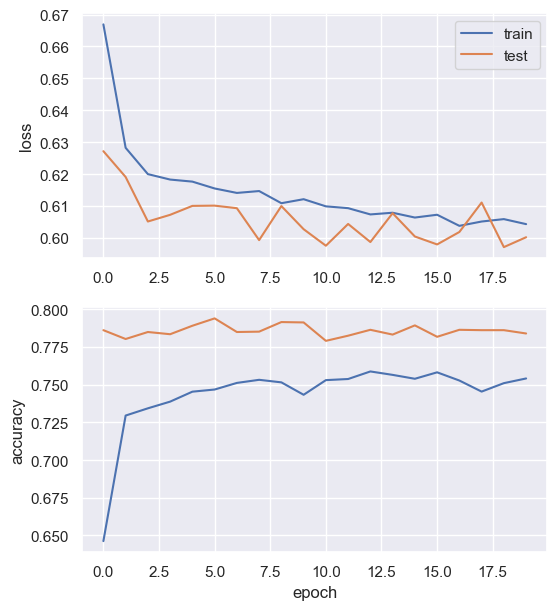

In [19]:
plot_train_test(train_losses, train_accuracy, test_losses, test_accuracy)

In [20]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader, DEVICE)
y_true, y_pred = y_true.cpu(), y_pred.argmax(1).cpu()

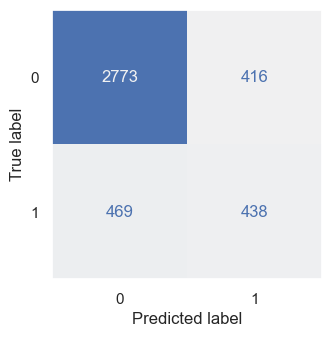

In [21]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=test_dataset.classes,
    colorbar=False,
    xticks_rotation=0,
    cmap=sns.color_palette('light:b', as_cmap=True)
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(3.5, 3.5)

In [22]:
print(metrics.classification_report(y_true, y_pred, target_names=test_dataset.classes, zero_division=True))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      3189
           1       0.51      0.48      0.50       907

    accuracy                           0.78      4096
   macro avg       0.68      0.68      0.68      4096
weighted avg       0.78      0.78      0.78      4096

